In [ ]:
# Basic operations
import numpy as np
import pandas as pd
import gensim

# LDA
from collections import Counter

# aesthetics
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from source import topic_modelling as tm

In [2]:
"""
First, we will perform classical exploratory analysis.
"""

df = pd.read_pickle('dfs/preprocessed-cleaned-df.pkl')
df.head()

,prompt,professor,student,professor_clean,student_clean,prompt_clean
0,You happen to know that Tim and Harry have rec...,"That's a great question! You see, our brains a...","Professor, I was thinking about how I conclude...","[great, question, brain, wire, look, plausible...","[professor, think, conclude, roommate, breakfa...","[happen, know, tim, harry, recently, terrible,..."
0,You happen to know that Tim and Harry have rec...,"Of course, you could be wrong! But here's the ...","But isn't that just an assumption? I mean, I c...","[course, wrong, thing, reasoning, base, probab...","[assumption, mean, wrong, roommate, eat, break...","[happen, know, tim, harry, recently, terrible,..."
0,You happen to know that Tim and Harry have rec...,"Ah, great example! This is where the concept o...","That makes sense, I guess. But what about case...","[great, example, concept, abduction, come, abd...","[make, sense, guess, case, explanation, clear,...","[happen, know, tim, harry, recently, terrible,..."
0,You happen to know that Tim and Harry have rec...,Exactly! Our minds are wired to seek patterns ...,"Yeah, I think so. It's like, our brains are al...","[exactly, mind, wire, seek, pattern, explanati...","[yeah, think, like, brain, try, find, story, e...","[happen, know, tim, harry, recently, terrible,..."
1,\n Even if it is true that we routinely rely o...,"Well, my inquisitive student, that's a great q...","Professor Phil, do we always choose the simple...","[inquisitive, student, great, question, mind, ...","[professor, phil, choose, simple, explanation,...","[true, routinely, rely, abductive, reasoning, ..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83 entries, 0 to 19
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   prompt           83 non-null     object
 1   professor        83 non-null     object
 2   student          83 non-null     object
 3   professor_clean  83 non-null     object
 4   student_clean    83 non-null     object
 5   prompt_clean     83 non-null     object
dtypes: object(6)
memory usage: 4.5+ KB


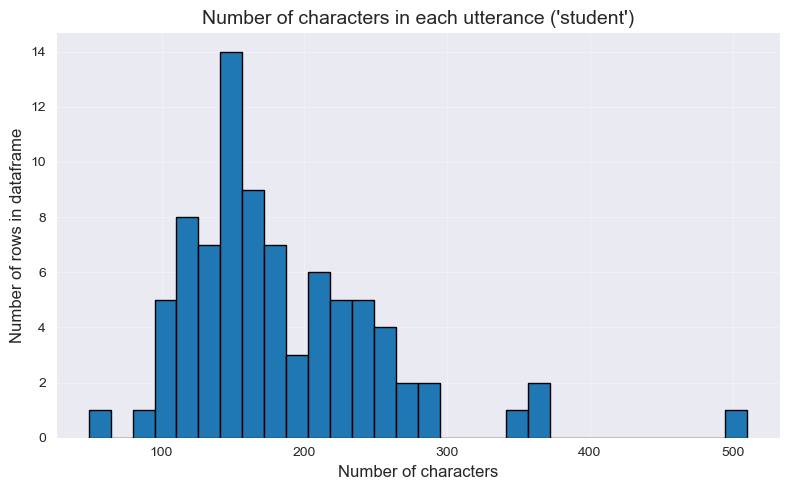

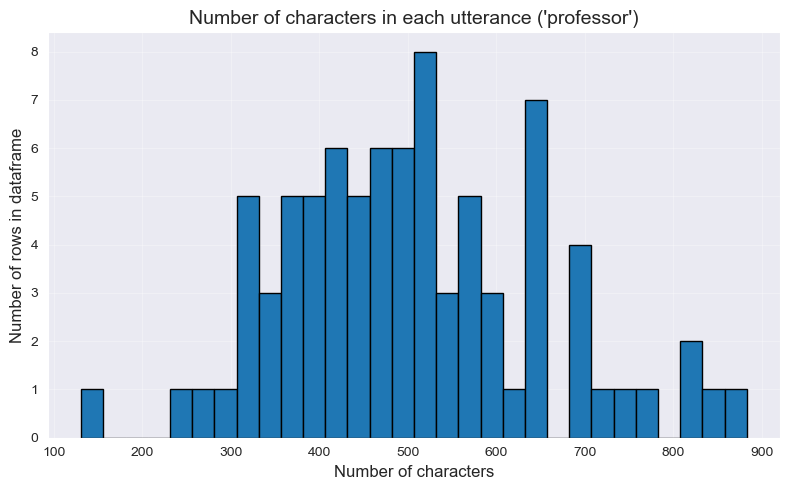

In [8]:
# number of characters in each utterance of each speaker
for column in ['student', 'professor']:
    plt.figure(figsize=(8, 5))
    df[column].str.len().hist(bins=30, edgecolor='black')
    plt.title(f"Number of characters in each utterance ('{column}')", fontsize=14)
    plt.xlabel("Number of characters", fontsize=12)
    plt.ylabel("Number of rows in dataframe", fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

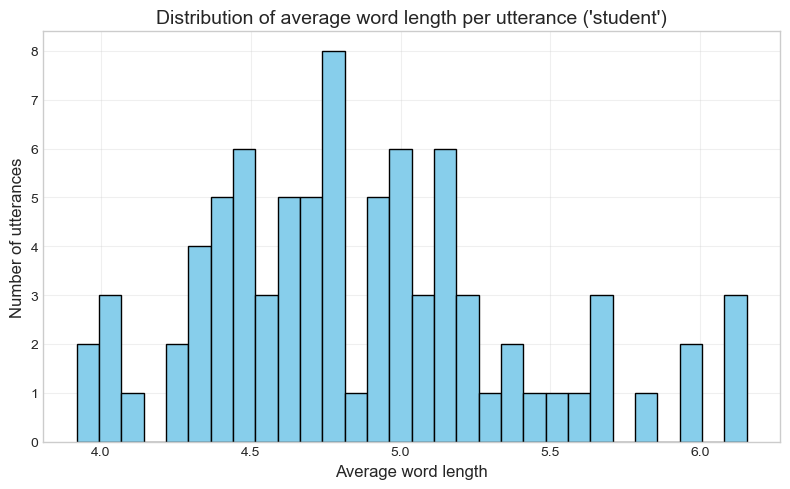

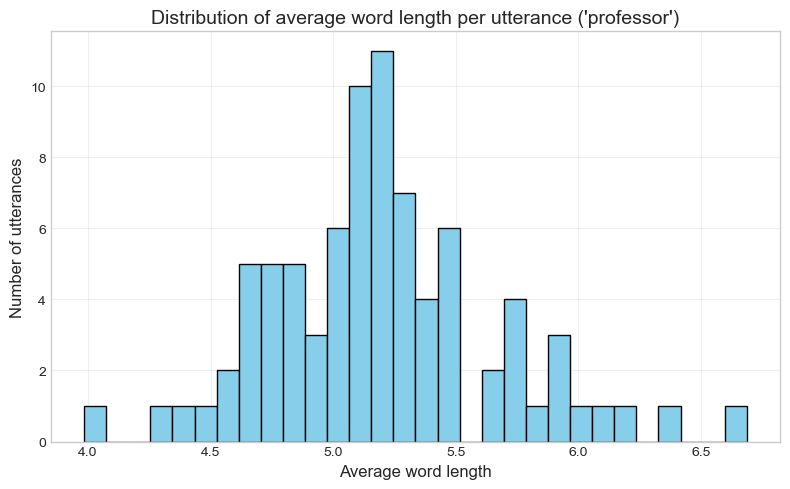

In [9]:
# distribution of average word length per utterance
plt.style.use('seaborn-v0_8-whitegrid')
for column in ['student', 'professor']:
    plt.figure(figsize=(8, 5))
    df[column].str.split() \
        .apply(lambda x: [len(i) for i in x]) \
        .map(np.mean) \
        .hist(bins=30, edgecolor='black', color='skyblue')

    plt.title(f"Distribution of average word length per utterance ('{column}')", fontsize=14)
    plt.xlabel("Average word length", fontsize=12)
    plt.ylabel("Number of utterances", fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_24624\2081902539.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="mako")


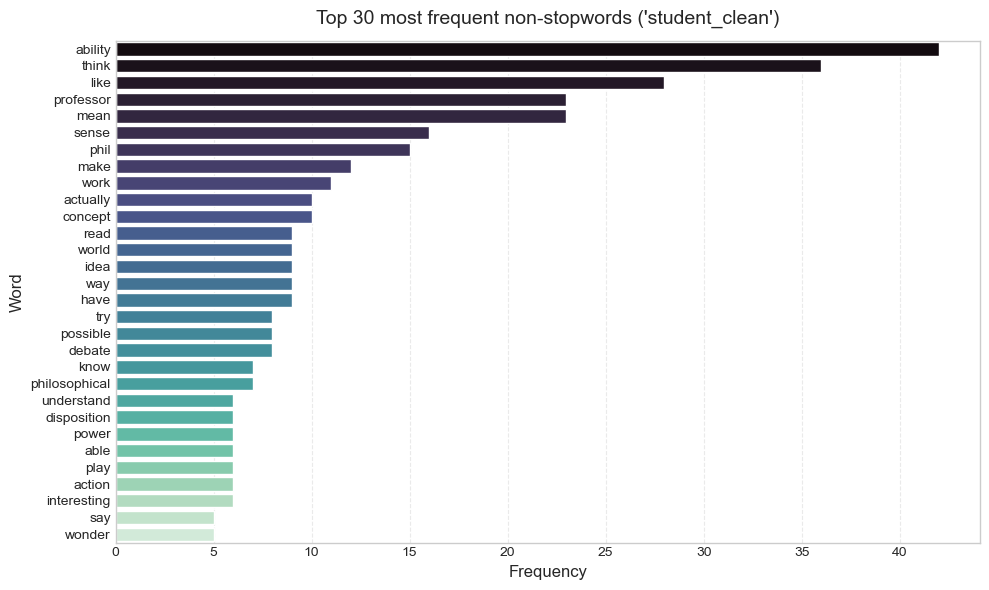

C:\Users\Dell\AppData\Local\Temp\ipykernel_24624\2081902539.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="mako")


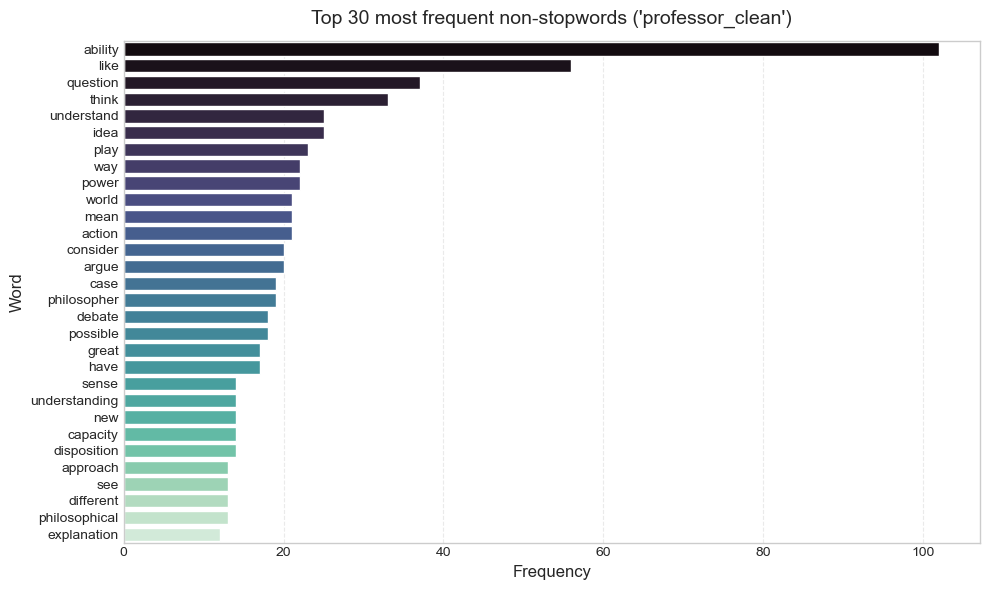

In [11]:
# The 30 most popular words
for column in ['student_clean', 'professor_clean']:
    corpus = [word for lemmas in df[column] for word in lemmas]
    counter=Counter(corpus)
    most=counter.most_common(30)
    words, counts = zip(*most)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words), palette="mako")
    plt.title(f"Top {30} most frequent non-stopwords ('{column}')", fontsize=14, pad=12)
    plt.xlabel("Frequency", fontsize=12)
    plt.ylabel("Word", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

In [ ]:
"""
Now it's time for topic modelling
"""
texts = df['professor_clean'] + df['student_clean']
dic=gensim.corpora.Dictionary(texts)
bow_corpus = [dic.doc2bow(doc) for doc in texts] # BOW

In [ ]:
# Search the space for the best solution
ev_metric = tm.find_best_LDA(
    corpus=bow_corpus,
    id2word=dic,
    passes=5,
    texts=texts,
    coherence='c_v',
    n_trials=3
)
ev_metric.to_csv(f'dfs/LDA_ev_metric.csv')

In [ ]:
print(ev_metric.head())

In [ ]:
# Run the best LDA model
best_lda = tm.create_LDA_model(corpus=bow_corpus,
                                num_topics=17,
                                id2word=dic,
                                passes=10)

In [ ]:
# Plot the results
tm.plot_lda_vis(lda_model=best_lda,
                corpus=bow_corpus,
                dic=dic)

In [ ]:
# Generate wordcloud
for column in ['student_clean', 'professor_clean']:
    wd_text = " ".join(df[column].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wd_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud of {column}")
    plt.show()